In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt

# Network statistics and labeling  
## **SNLP team project**

In [2]:
df_labels = pd.read_csv('community_labels.csv', header=0)

In [3]:
df_labels.columns

Index(['Id', 'Label', 'timeset', 'Cluster'], dtype='object')

In [4]:
df = pd.read_json('../../tweet_data/preprocessed/text/tweets_climate_en_text_20200812.json',  orient = "records", dtype = False, lines = True, encoding = "utf-8")
GX_full = pd.read_pickle('../../tweet_data/graphs/full_networks_directed-20200812.pickle')
GX_lc = pd.read_pickle('../../tweet_data/graphs/lc_networks_directed-20200812.pickle')

#### **Network stats:** number of nodes and edges

In [5]:
print('Number of nodes:\n * full network: {:>11}\n * largest component: {}'.format(GX_full[1].number_of_nodes(), GX_lc[1].number_of_nodes()))

Number of nodes:
 * full network:      809157
 * largest component: 625893


In [6]:
print('Number of edges:\n * full network: {:>12}\n * largest component: {}'.format(GX_full[1].number_of_edges(), GX_lc[1].number_of_edges()))

Number of edges:
 * full network:      1089988
 * largest component: 1066722


In [7]:
print('Largest component retains\n * fraction of nodes: {:.2f}\n * fraction of edges: {:.2f}'.format( GX_lc[1].number_of_nodes() / GX_full[1].number_of_nodes(),
                                                                                                      GX_lc[1].number_of_edges() / GX_full[1].number_of_edges()))

Largest component retains
 * fraction of nodes: 0.77
 * fraction of edges: 0.98


#### **Share of retweets vs original tweets**

In [8]:
df.columns

Index(['content', 'created_at', 'id_str', 'user_id_str', 'parent_tweet_id_str',
       'parent_user_id_str', 'coordinates'],
      dtype='object')

In [9]:
idxs_random = np.random.choice(range(df.shape[0]), 50)

Find the pseudonymized id for the missing values:

In [10]:
df['parent_tweet_id_str'].mode()

0    83992313
dtype: int64

In [11]:
num_rts = np.sum(df['parent_tweet_id_str'] != 83992313)
print('Number of tweets in the data: {}'.format(df.shape[0]))
print('Number of retweets: {}, fraction of all tweets: {:.2f}'.format(num_rts, num_rts / df.shape[0]))

Number of tweets in the data: 1614860
Number of retweets: 1214704, fraction of all tweets: 0.75


**Conclusion**: 75% of the tweets in the data are retweets which means that 25% or ca. 0.4 million of the tweets are original tweets.

#### **Presence of geocoordinates**

In [12]:
num_gc = np.sum(df.coordinates.notna())
print('Number of tweets that include geocoordinate data: {}, fraction of all tweets: {:.5f}'.format(num_gc, num_gc / df.shape[0]))

Number of tweets that include geocoordinate data: 188, fraction of all tweets: 0.00012


**Conclusion**: Only 1 in every 10000 tweets, or 188 tweets altogether, include geocoordinate data.

#### **iGraph export**

Export networkx retweet network as graphml file for more efficient network computations:

In [13]:
retweet_netw_indx = 1
G = GX_lc[retweet_netw_indx] # Select retweet network
filename = 'snlp_climate_retweet_netw.graphml'
nx.write_graphml(G, filename) # Export NX graph to file

In [14]:
Gix = ig.read(filename,format="graphml") # Create new IG graph from file

#### **Verify social network characteristics**
We will look into the basic structural measures / characteristics of the retweet network to verify that it fulfills the basic characteristics of social network.  

In [15]:
degs = Gix.degree_distribution()

In [16]:
r0, r1, freq = zip(*degs.bins())

In [17]:
X,Y = zip(*[(i+1,x) for i,x in enumerate(freq) if x > 0])

Average degree

In [18]:
degs.mean

3.408640134975047

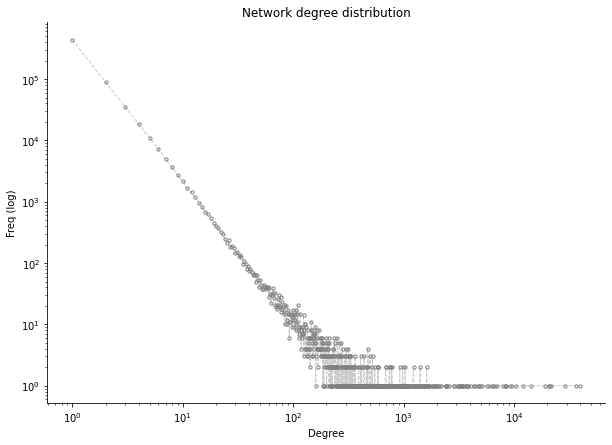

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Network degree distribution')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Freq (log)')
ax.set_xlabel('Degree')
ax.set_gid('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(X,Y, '--', lw=1.0, fillstyle='none', color='gray', alpha=0.4)
plt.plot(X,Y, 'o', ms=3.2, fillstyle='none', color='gray')
fig.savefig('degree_distribution.pdf')

Degree distribution follows powerlaw / Zipf's distribution as is typical for social networks; in other words top degree nodes are extremely rare but they have high degree values. Average degree is only 3.4.  

Density

In [25]:
Gix.density()

2.7230258055504367e-06

Average clustering coefficient

In [26]:
Gix.transitivity_undirected()

0.0001480117032277105

Both density and avg clustering coefficient of the network are very small releaving that the network is very sparse. This is due to the short time series that the data has been collected over. As number of edges increase proportional to $|V|^2$, where $V$ is the set of nodes in the network, longer time period would yield us more densely connected network.

Diameter

In [27]:
Gix.diameter()

26

Diameter is relatively long whereas for typical social networks, this is < 10. This is most probably also explained by the short time period of the collection / sampling and possibly very wide geographical area of collection (no restrictions).

Assortativity

In [91]:
Gix.assortativity_degree()

-0.06196024095762551

Network's assortativity is intrestingly also slightly negative which is atypical for social networks for which assortativity is often > 0.1. [\[1](https://arxiv.org/pdf/cond-mat/0205405.pdf)\]. However this could be explained by the sparsity of the network.

#### **Partitioning using Leiden**

#### Export to gephi

In [51]:
attrs = ['interactions', 'retweets', 'mentions', 'follows']
for G, attr in zip(GX_lc, attrs):
    with open('gephi_{}.csv'.format(attr), 'w') as file:
        file.write('{},{},{}\n'.format('source','target','weight'))
        for u,v,w in G.edges(data=attr):
            file.write('{},{},{}\n'.format(u,v,w))

In gephi we visualize the retweet network using force directed network layout algorithm (ForceAtlas 2). We use these visualizations as the first heuristics in order to identify the clusters / echo chambers in the retweet network. As can be seen from the figs \[[1]('../../figs/1.fig_3cs_community_detection_1e-6.png')\] and \[[2]('../../figs/2.fig_final_community_detection2e-07.png')\], network present clear separation into communities which both the layout as well as community detection methods agree upon. We use Leiden algorithm with CPM (Constant Potts Model) quality function because of its multiple favorable properties including scalability, ability to process directed networks and explicit guarantees. 

**Picking resolution parameter:**
* Using resolution parameter $\gamma = 10^{-6}$ yields 2248 communities with three largest communities (53.26%, 18.96%, 14.57%) include 86.79% of the nodes in the network, quality of the partitioning is > 0.91. Further fine-tuning leads us to select $\gamma = 2\cdot10^{-7}$ as the final parameter choice, yielding all in all 182 communities, with 2 major communities (81.86%, 13.59%) including 95.45% of the nodes in the network and quality of the partitioning > 0.97. 

In the following we will do a quick manual inspection of the attitudinal alignment of the sentiment within different communities: 